## Higgs Effective Field Theory (HEFT) Study
## Approximate $\mathbb{P}(\lambda \le \lambda_0 | \theta) = \mathbb{E}(Z | \theta)$ by histogramming
> Created: Feb 12, 2024 Nicola de Filippis, Kurtis Johnson, Harrison B. Prosper<br>

### Introduction
The purpose of this project is to approximate $\mathbb{P}(\lambda \le \lambda_0 | \theta) = \mathbb{E}(Z | \theta)$ in two different ways: 1) using a 3D histogram and 2) a machine learning (ML) model, where for a given hypothesis $H_0: \theta = \theta_0$ versus $H_1: \theta \ne \theta_0$, $\lambda_0$ is the observed value of a test statistic $\lambda$ with the property that large values of the test statistic *disfavor* the hypothesis $H_0$. In this project, the physics model of interest is the Higgs effective field theory (HEFT), defined by a 5D parameter space of Wilson coefficients[1]:
\begin{align}
    \theta & = c_{hhh}, c_t, c_{tt}, c_{ggh}, c_{gghh}.
\end{align}

For this investigation, we restrict our attention to a single observable, namely, the di-Higgs mass denoted by $m_{hh}$. This notebook plots the cross section per 15 GeV in $m_{hh}$ [1]
\begin{align}
    d\sigma 
    & = a_{1} c_{t}^{4} + a_{2} c_{tt}^{2} + a_{3} c_{t}^{2} c_{hhh}^{2} + a_{4} c_{ggh}^{2} c_{hhh}^{2}
    \nonumber\\
    & + a_{5} c_{gghh}^{2} + a_{6} c_{t}^{2} c_{tt} + a_{7} c_{t}^{3} c_{hhh} 
    \nonumber\\
    & + a_{8} c_{t} c_{hhh} c_{tt} + a_{9} c_{ggh} c_{hhh} c_{tt} + a_{10} c_{gghh} c_{tt} 
    \nonumber\\ 
    & + a_{11} c_{t}^{2} c_{ggh} c_{hhh} + a_{12} c_{t}^{2} c_{gghh} 
    \nonumber\\
    & + a_{13} c_{t} c_{ggh} c_{hhh}^{2} + a_{14} c_{t} c_{gghh} c_{hhh} \nonumber\\
    & + a_{15} c_{gghh} c_{ggh} c_{hhh} + a_{16} c_{t}^{3} c_{ggh} \nonumber\\
    & + a_{17} c_{t} c_{ggh} c_{tt} + a_{18} c_{t} c_{ggh}^{2} c_{hhh}  \nonumber\\
    & + a_{19} c_{t} c_{gghh} c_{ggh} + a_{20} c_{t}^{2} c_{ggh}^{2}  \nonumber\\ 
    & + a_{21} c_{ggh}^{2} c_{tt} + a_{22} c_{ggh}^{3} c_{hhh} \nonumber\\
    & + a_{23} c_{gghh} c_{ggh}^{2} , 
\end{align}
for each HEFT parameter point, where the coefficients $a_i$ depend on the di-Higgs mass $m_{hh}$. In this investigation, we set $c_{hhh} = c_t = 1$, which reduces the parameter space to 3 dimensions. 
This yields the expression,
\begin{align}
    d\sigma(m_{gg}, \theta) & = \boldsymbol{c}^T(\theta) \cdot \boldsymbol{b}(m_{hh}), 
\end{align}
for the cross section per bin, where
\begin{align}
    \boldsymbol{c}^T(\theta) & = (1, 
                 c_{tt}, 
             c_{ggh}, 
             c_{gghh}, \nonumber\\
             &\quad\,\,\,\, c_{tt} c_{ggh},
             c_{tt} c_{gghh}, 
             c_{ggh}c_{gghh}, \nonumber\\
             &\quad\,\,\,\, c_{tt} c_{ggh}^2, 
             c_{gghh} c_{ggh}^2, 
             c_{tt}^2, 
             c_{gghh}^2, 
             c_{ggh}^2, 
             c_{ggh}^3), 
\end{align}
is a row matrix of polynomials in the HEFT parameters
and $\boldsymbol{b}(m_{hh})$ is a column matrix of coefficients.

### Approximating $\mathbb{P}(\lambda \le \lambda_0 | \theta) = \mathbb{E}(Z | \theta)$ by histogramming

The quantity $\mathbb{E}(Z | \theta)$ can be approximated using the following algorithm.

  1. Create histogram $h_Z \gets \text{histogram}(\theta, \text{weight}=Z)$
  1. Create histogram $h_1 \gets \text{histogram}(\theta, \text{weight}=1)$
  1. Approximate $\mathbb{P}(\lambda \le \lambda_0 | \theta)$ by $h_Z \, / \, h_1$

For a multi-dimensional histogram, we'll use the module $\texttt{turtlebinning}$, which is a wrapper around the ROOT class TKDTreeBinning.

### References
  1. Lina Alasfar *et al.*, arXiv:2304.01968v1
  1. Ann Lee *et al.*, https://arxiv.org/abs/2107.03920

In [1]:
import os, sys

# the standard module for tabular data
import pandas as pd

# the standard module for array manipulation
import numpy as np

# the standard modules for high-quality plots

import matplotlib as mp
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# update fonts
FONTSIZE = 16
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)

# set usetex = False if LaTex is not 
# available on your system or if the 
# rendering is too slow
mp.rc('text', usetex=True)

### Load data

Note 1: $\kappa_\lambda \equiv c_{hhh}$.

Note 2: The bin widths in $m_{hh}$ is 15 GeV.

In [3]:
def read_data(datafiles):
    df = []
    for datafile in datafiles:
        print('reading %s' % datafile)
        df.append( pd.read_csv(datafile) )

    # concatenate dataframes
    df = pd.concat(df)
    
    # select points with klambda=CT=1
    select = (df.klambda==1) * (df.CT==1)
    
    # make number of rows be a multiple of 20
    total  = select.sum()
    total  = int(total / 20)
    total  = 20 * total
    
    df = df[select][:total]
    print('\nnumber of rows read: %d\n' % len(df))

    # randomly shuffle order of rows in dataframe
    df = df.sample(frac=1).reset_index(drop=True)
    return df

In [4]:
datafiles = ['../data/powheg_total_param_closeBP.csv', 
             '../data/powheg_total_param_closeBP_all.csv']

dfBP = read_data(datafiles)
dfBP[:5]

reading ../data/powheg_total_param_closeBP.csv
reading ../data/powheg_total_param_closeBP_all.csv

number of rows read: 340



,klambda,CT,CTT,CGHH,CGGHH,0,1,2,3,4,...,92,93,94,95,96,97,98,99,100,101
0,1.0,1.0,0.5,0.8000,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.000254,0.000136,0.000068,0.000056,0.000153,0.000288,0.000187,0.000153,0.000119,0.002256
1,1.0,1.0,-3.0,-0.8000,1.0000,0.0,0.0,0.0,0.0,0.0,...,0.009819,0.015541,0.018812,0.009818,0.016354,0.008987,0.010645,0.008175,0.013896,0.297774
2,1.0,1.0,0.5,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.000117,0.000138,0.000129,0.000121,0.000138,0.000069,0.000130,0.000121,0.000069,0.001815
3,1.0,1.0,-1.5,0.8000,-1.0000,0.0,0.0,0.0,0.0,0.0,...,0.003883,0.012274,0.007111,0.007109,0.007119,0.005802,0.009703,0.007110,0.002582,0.124792
4,1.0,1.0,-1.5,0.5333,0.0666,0.0,0.0,0.0,0.0,0.0,...,0.002351,0.001762,0.001175,0.001760,0.001466,0.001174,0.002940,0.002054,0.002055,0.031877


In [5]:
datafile = f'../data/powheg_total_param_SM.csv'

print('loading %s' % datafile)
dfSM = pd.read_csv(datafile)
print('number of rows:', len(dfSM))

dfSM

loading ../data/powheg_total_param_SM.csv
number of rows: 1


,klambda,CT,CTT,CGHH,CGGHH,0,1,2,3,4,...,92,93,94,95,96,97,98,99,100,101
0,1,1,0,0,0,0,0,0,0,0,...,0.000031,0,0.00001,0.000042,0,0.00001,0.000042,0.00001,0.000031,0.000157


### Convert to $\texttt{numpy}$ arrays

In [6]:
# get Wilson coefficients
wilson = dfBP[['CTT', 'CGHH', 'CGGHH']].to_numpy()
print(wilson.shape)

# get spectra
first_bin= 17
last_bin = 96

# construct bin names
cols = [str(x) for x in range(first_bin, last_bin+1)]
BP = dfBP[cols].to_numpy()
SM = dfSM[cols].to_numpy()

print(BP.shape)

(340, 3)
(340, 80)


### Get total cross sections (in pb) and protect against negative HEFT bins

In [7]:
SM.min(), SM.max(), BP.min(), BP.max()

(0.0, 0.017281655, -0.0002928526955656, 2.342081546783448)

In [8]:
BP = np.where(BP < 0, 0, BP) # protect against negative cross sections

# get total cross sections
SM_xsec = SM.sum()
print(f'cross section (SM): \t\t{SM_xsec:8.3f} pb')

BP_xsec = BP.sum(axis=1)
print(f'cross section (BP) (min, max):  {BP_xsec.min():8.3f} pb, {BP_xsec.max():8.3f} pb')

cross section (SM): 		   0.223 pb
cross section (BP) (min, max):     0.065 pb,   43.738 pb


### Plot $m_{hh}$ spectra

In [9]:
def plot_spectra(d, ymax=2.5, alpha=0.5, ylabel=r'$d\sigma$ (pb)',
                 filename='figures/fig_mhh.pdf', 
                 fgsize=(8, 4), ftsize=18):

    # compute mid-points of bins and map mhh to unit interval
    m, xbins = d.shape
    xmin = 0
    xmax = xbins/100
    x = np.linspace(xmin, xmax, xbins+1)
    
    # x[1:] = x[1], x[2] ...,x[n-1]
    # x[:-1]= x[0], x[1],...,x[n-2]
    x = (x[1:]+x[:-1])/2

    # make a plot with a single figure
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=fgsize)

    ax.set_xlim(xmin, xmax)
    ax.set_xlabel(r'$m_{hh}$', fontsize=ftsize)

    ymin = 0
    ax.set_ylim(ymin, ymax)
    ax.set_ylabel(ylabel, fontsize=ftsize)
    
    # loop over HEFT points
    for row in d:
        ax.hist(x, 
                bins=xbins, 
                range=(xmin, xmax), 
                weights=row,
                alpha=alpha)
    ax.grid() 
    
    plt.tight_layout()
    plt.savefig(filename)
    return

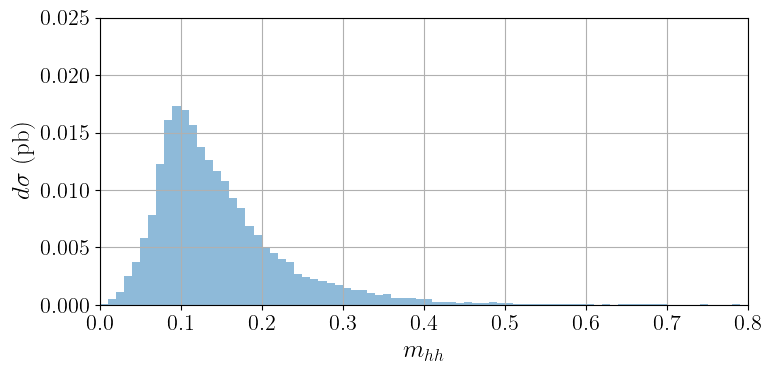

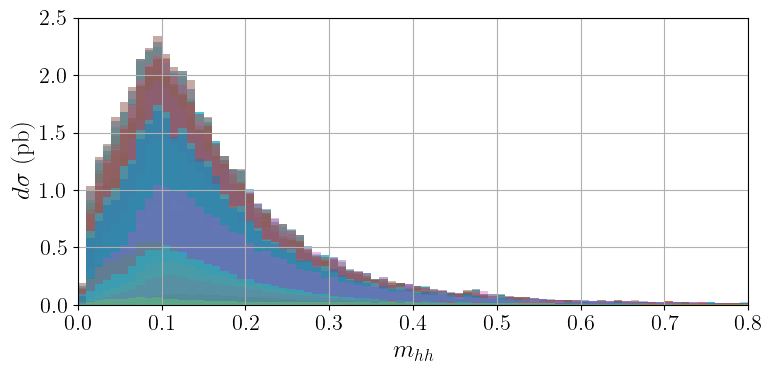

In [10]:
plot_spectra(SM, ymax=0.025, filename='figures/fig_mhh_SM.pdf')
plot_spectra(BP, ymax=2.50, filename='figures/fig_mhh_BP.pdf')

### Construct "observed" spectrum

Given the effective integrated luminosity, $\ell = \epsilon {\cal L}$, the mean event count is $n = \sigma \, {\cal L}$, where $\sigma$, $\epsilon$, and ${\cal L}$ are the total cross section, the efficiency (times acceptance) and integrated luminosity, respectively. 

We'll assume an effective integrated luminosity such that the mean `SM_mean_count` $= 10$ events. Then we sample from the SM $m_{hh}$ spectrum to mimic the *fixed* "observed" data, $D$, and we sample from the predicted spectrum at each of the HEFT parameter points taking care to use the correct mean counts relative to that of the SM.

  1. Compute the effective integrated luminosity
  2. Compute the Poisson mean for each bin
  3. Create "observed" $m_{hh}$ spectrum by sampling each bin independently using a Poisson sampler.
  4. For each HEFT point, generate data from the predicted spectrum.

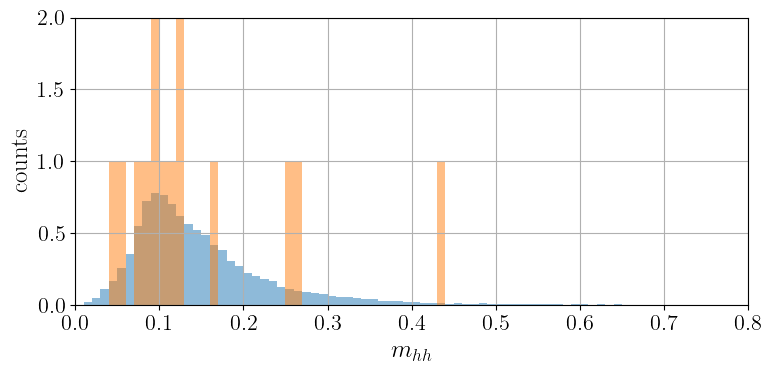

In [21]:
SM_mean_count = 10

# effective integrated luminosity
L_eff = SM_mean_count / SM_xsec

# compute Poisson means
SM_A = SM * L_eff

# generate "observed" data
D = np.random.poisson(SM_A)

# make a plot
T = np.concatenate([SM_A, D])
plot_spectra(T, ymax=2.0, ylabel='counts', filename='figures/fig_mhh_obs.pdf')

### Generate spectrum $X_j$ at each HEFT point $\theta_j$
In general, the efficiency will vary across the HEFT parameter space. But, for now, we'll assume the same effective integrated luminosity at each HEFT point.

(341, 80) (341, 80)


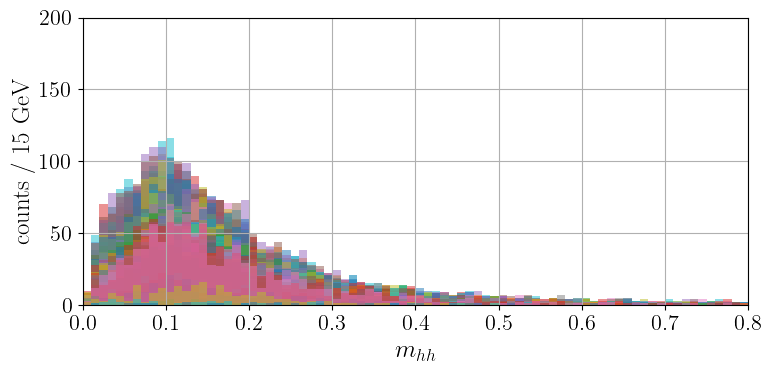

In [22]:
# compute mean counts at each HEFT point
BP_A = BP * L_eff 

# generate data at each HEFT point
X = np.random.poisson(BP_A)
print(X.shape, BP_A.shape)

# make a plot
plot_spectra(X, ymax=200, ylabel='counts / 15 GeV', filename='figures/fig_mhh_X.pdf')

### Construct test statistic

For now, we'll use the following simple test statistic,
\begin{align}
    \lambda(X; \theta) & = \sqrt{\frac{1}{M} \sum_{i=1}^M \frac{(X_i - T_i(\theta))^2}{T_i(\theta)}},
\end{align}
where $M$ is the number of bins. Note, as required,  large values of $\lambda$ cast doubt on the hypothesis $H_0 : \theta = \theta_0$.

In [23]:
def test_statistic(X, T, T_min=0):
    v = np.where(T > T_min, T, 1) # variances
    l = (X - T)**2 / v
    return np.sqrt(l.mean(axis=1))

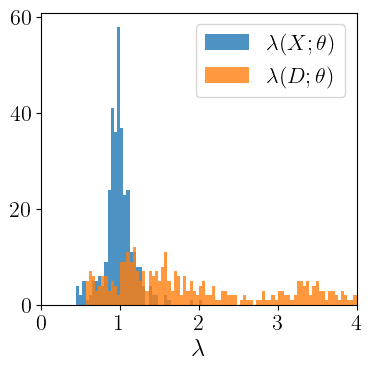

In [24]:
def plot_test_statistics(lx, l0, xbins=100,
                 filename='figures/fig_test_stats.pdf', 
                 fgsize=(4, 4), ftsize=18):

    # make a plot with a single figure
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=fgsize)

    xmin, xmax = 0, 4
    ax.set_xlim(xmin, xmax)
    ax.set_xlabel(r'$\lambda$', fontsize=ftsize)
    ax.hist(lx, bins=xbins, range=(xmin, xmax), alpha=0.8, label=r'$\lambda(X;\theta)$')
    ax.hist(l0, bins=xbins, range=(xmin, xmax), alpha=0.8, label=r'$\lambda(D;\theta)$')
    ax.legend()
    
    plt.tight_layout()
    plt.savefig(filename)

# compute test statistics and plot their distributions
lx = test_statistic(X, BP_A)
l0 = test_statistic(D, BP_A)

plot_test_statistics(lx, l0)

### Compute indicators $Z_j = \mathbb{I}[\lambda(X_j; \theta_j) \leq \lambda(D; \theta_j)]$

For every HEFT parameter point $\theta_j = (c_{tt}, c_{ggh}, c_{gghh})_j$ compute $Z_j$.

In [25]:
Z = (lx <= l0).astype(int)
Z

array([1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,

### Bin HEFT parameter points using $\texttt{turtlebinning}$

The parameter points to be binned, $\{(c_{tt,i}, c_{ggh,i}, c_{gghh,i}), i=1,\cdots,N \}$ must be flattened into a single array arranged as follows:
$c_{tt,1},\cdots,c_{tt,N}, c_{ggh,1},\cdots,c_{ggh,N}, c_{gghh,1},\cdots,c_{gghh,N}$. The $\texttt{numpy}$ array `wilson` is of shape (168, 3), so we must first transpose it to shape (3, 168) before we flatten it to ensure that the data are arranged as needed.

See the example below.

In [26]:
a = np.array([[1,2,3], [1,2,3], [1,2,3], [1,2,3]])
a.shape, a, a.T.flatten()

((4, 3),
 array([[1, 2, 3],
        [1, 2, 3],
        [1, 2, 3],
        [1, 2, 3]]),
 array([1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3]))

$\texttt{turtlebinning}$ is a convenient wrapper arpund the ROOT class TKDTreeBinnning.

In [27]:
import turtlebinning as tb
from array import array

Welcome to JupyROOT 6.30/02
	loading turtlebinning


Add a bit of noise to the HEFT parameter points to ensure they are not perfectly aligned.

In [31]:
points = np.random.normal(wilson[:340], 0.001)
points.shape 

(340, 3)

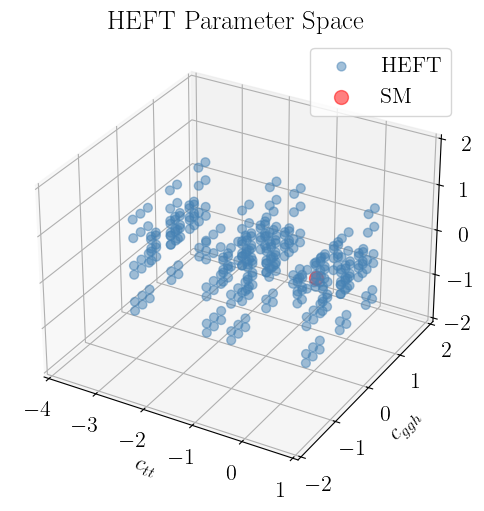

In [32]:
def plot_points(points, 
                filename='figures/fig_heft_points.pdf', 
                fgsize=(5, 5), 
                ftsize=16):

    # make a plot with a single figure
    fig, ax = plt.subplots(nrows=1, ncols=1, 
                           subplot_kw={"projection": "3d"}, 
                           figsize=fgsize)
    plt.tight_layout()
    
    xmin, xmax = -4, 1
    ymin, ymax = -2, 2
    zmin, zmax = -2, 2

    ax.set_title('HEFT Parameter Space')
    
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_zlim(zmin, zmax)
    
    ax.set_xlabel(r'$c_{tt}$', fontsize=ftsize)
    ax.set_ylabel(r'$c_{ggh}$', fontsize=ftsize)
    ax.set_zlabel(r'$c_{gghh}$', fontsize=ftsize)

    x, y, z = points.T
    ax.scatter(x, y, z, s=40, color='steelblue', alpha=0.5, label='HEFT')
    ax.scatter([0], [0], [0], s=100, color='red', alpha=0.5, label='SM')
    ax.legend()
    
    plt.savefig(filename)

plot_points(points)

 1. Create a C-like array containing the HEFT points
 2. Bin the HEFT points
 3. For each bin get the list of HEFT points within it and verify that the number of points/bin is constant, as it should be.

In [33]:
# create a simple (i.e., a non-numpy) array
data = array('d')
# transpose and flatten the HEFT points array
data.extend(points.T.flatten())

# bin HEFT parameter points
npoints = len(points) # number of HEFT parameter points
nbins = 20            # number of bins
ndims = 3             # dimension of parameter space
ttb   = tb.Turtle(data, nbins, npoints, ndims)

# check that each bin contains the same number of points
for i in range(nbins):
    n = ttb.indices(i)
    print(len(n), n)

17 { 0, 40, 46, 50, 58, 86, 101, 103, 104, 125, 167, 220, 223, 246, 272, 303, 315 }
17 { 4, 43, 59, 70, 128, 129, 130, 147, 227, 229, 230, 269, 275, 277, 290, 311, 327 }
17 { 24, 64, 67, 77, 92, 100, 106, 114, 131, 137, 140, 206, 233, 244, 268, 278, 300 }
17 { 61, 89, 110, 142, 144, 145, 148, 157, 174, 196, 201, 208, 211, 226, 301, 306, 307 }
17 { 10, 13, 14, 26, 98, 123, 133, 179, 191, 197, 231, 234, 236, 243, 262, 284, 338 }
17 { 6, 22, 25, 30, 49, 51, 72, 76, 82, 124, 127, 143, 153, 260, 283, 298, 312 }
17 { 75, 83, 171, 177, 198, 205, 209, 210, 218, 248, 251, 259, 281, 282, 320, 321, 335 }
17 { 18, 31, 33, 57, 62, 74, 90, 93, 113, 116, 180, 184, 195, 256, 266, 293, 305 }
17 { 1, 17, 19, 23, 45, 47, 94, 186, 212, 239, 247, 263, 280, 302, 318, 325, 328 }
17 { 2, 85, 91, 149, 150, 154, 155, 156, 164, 204, 240, 249, 253, 310, 314, 329, 334 }
17 { 21, 68, 172, 175, 181, 183, 189, 199, 217, 252, 279, 285, 291, 304, 308, 322, 326 }
17 { 8, 27, 37, 39, 108, 141, 169, 203, 225, 235, 242, 28

### Use kdtree bins to created weighted histogram and estimate CDF

 1. Clear bins
 2. Fill bins using $Z$ indicators as weights
 3. Estimate $\mathbb{P}(\lambda \le \lambda_0 | \theta) = \mathbb{E}(Z | \theta) \approx h_Z / h_1$, where $h_Z$ is the histogram weighted with $Z$ and $h_1$ is the histogram weighted with unity. 

In [34]:
ttb.clear()
for x, z in zip(points, Z):
    p = array('d', list(x))
    ttb.fill(p, z)

# Note: the method counts() returns the count in each bin as a C++ vector
# convert to a numpy array
num = np.array( ttb.counts() )

cdf = num / ttb.entriesPerBin()
res = list(zip(cdf, range(len(cdf))))
res.sort()

print('%8s %8s' % ('cdf', 'point'))
for p, i in res:
    print(f'{p:8.2f} {i:8d}')

     cdf    point
    0.24       11
    0.41        9
    0.53        5
    0.53        7
    0.65        8
    0.76        4
    0.82        6
    0.82       10
    0.88        3
    0.88       15
    1.00        0
    1.00        1
    1.00        2
    1.00       12
    1.00       13
    1.00       14
    1.00       16
    1.00       17
    1.00       18
    1.00       19
